In [1]:
import numpy as np
import tempfile
import os
import matplotlib.pyplot as plt
import scipy.io as sci
import scipy.fftpack as sff

**I - Data generation and manipulation**

The objective of this first short part is to create some datasets to get accustomed to them. It will enable us to :
- recall the notion of sparsity ;
- geometrically understand the effect of the mixing.

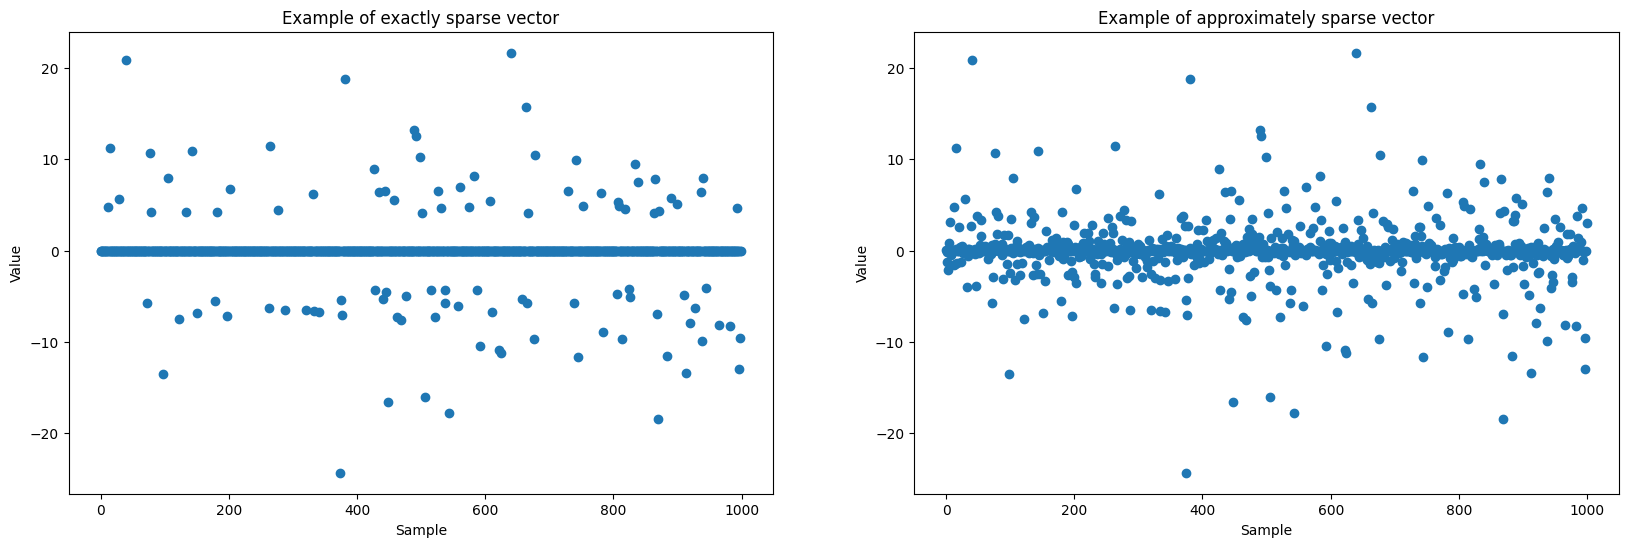

In [2]:
power = 3
approx_sparse = np.random.randn(1000)**power
exact_sparse = approx_sparse*(np.abs(approx_sparse)>4)

fig = plt.figure(figsize=(20, 6))
fig.add_subplot(1,2,1)
plt.plot(exact_sparse, 'o')
plt.xlabel('Sample')
plt.ylabel('Value')
plt.title('Example of exactly sparse vector');

fig.add_subplot(1,2,2)
plt.plot(approx_sparse, 'o')
plt.xlabel('Sample')
plt.ylabel('Value')
plt.title('Example of approximately sparse vector');

What is the difference between an exactly and an approximately sparse signal? Recall the two corresponding definitions.

A sparse signal have a lot values equal to 0 whereas an approximately sparse signal have a lot of values nearly equal to 0.

Now let's start to look at some mixtures and to try to geometrically interpret the impact of the mixing.

First, generate a simulated source S matrix. Plot the corresponding scatter plot. Interpret the shape of the scatter plot you obtain.

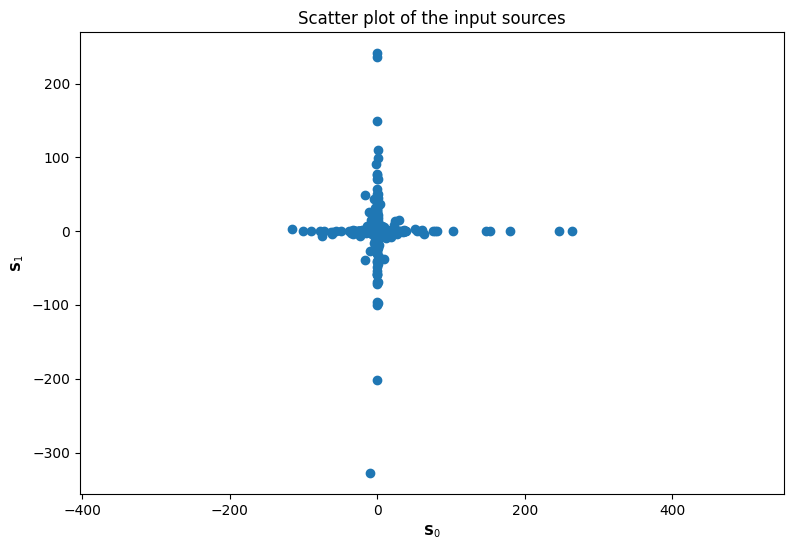

In [3]:
n = 2         # number of sources
t = 1024      # number of samples
noise_level = 80 # noise level, in dB
power = 5 # power exponent used in the source generation

# TO DO : generate a simulated source S matrix. 
# S will be of dimensions n x t.
# Each of the n sources (i.e. lines of S) will follow the approximately sparse 
# law we used above.
S = np.zeros((n, t)) # TO CHANGE
for i in range(n):
  S[i] = np.random.randn(t)**power

fig = plt.figure(figsize=(20, 6))
fig.add_subplot(1,2,1)
plt.title('Scatter plot of the input sources')
plt.plot(S[0, :], S[1, :], 'C0o')
plt.xlabel("$\mathbf{S}_0$")
plt.ylabel("$\mathbf{S}_1$")
plt.axis('equal');

We obtain a cross with a lot of values around (0, 0) and other values on the lines (Ox) (Oy). Therefore, we have a sparse signal from a mixing of two sparse signals.

In [4]:
# Here, we generate a mixture matrix (dimensions m x t) from the sources in S  
m = 4         # number of observations

A = np.random.randn(m,n)
X = A@S

noise_level = 120

# To be more realistic, we add some noise to the mixing. 
# Mixtures with SNR > 120 dB can be considered as noiseless for most applications.
if noise_level < 120: 
    #--- Add noise
    N = np.random.randn(m,t)
    N = 10.**(-noise_level/20.)*np.linalg.norm(X)/np.linalg.norm(N)*N
    X = X + N

Plot the scatter plot of X. What do you see ? 

What do the directions of the lines you observe correspond ?

Try several A matrices, noise_values and powers. Any comment?

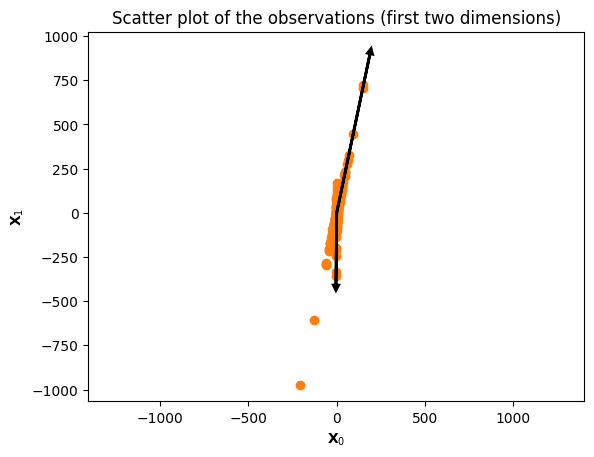

In [5]:
plt.title('Scatter plot of the observations (first two dimensions)')
vrange = 0.25*max(np.sqrt(np.sum(X*X, 0)))
plt.arrow( 0, 0, vrange*A[0, 0], vrange*A[1, 0], fc="k", ec="k", linewidth=2, head_width=0.1*vrange, head_length=0.1*vrange)
plt.arrow( 0, 0, vrange*A[0, 1], vrange*A[1, 1], fc="k", ec="k", linewidth=2, head_width=0.1*vrange, head_length=0.1*vrange)
plt.plot(X[0,:], X[1,:], 'C1o', zorder=0)
plt.xlabel("$\mathbf{X}_0$")
plt.ylabel("$\mathbf{X}_1$")
plt.axis('equal');

The arrows shows the direction of the component of the observation matrix.
More the signal is sparse (with a greater value of power), less the noise impacts and the signal can be easily separated. 

**II - Performing non-blind source separation**

**1) Data generation**

Before going into blind source separation, in which we want to find physical **A** and **S** matrices such that **X = AS + N**, let us first consider the simpler setting in which we know **A** and want to recover **S**.
We will consider the noisy mixture of two sine signals. The methodology extends to more complex datasets.

N.B. : unmixing two sinus signal could be done much more easily than using the algorithms we saw during the class. Nevertheless, focusing on such synthetic data enables an easy visualization. The principle readily extend to more complex datasets, such as images.

(-25.0, 25.0)

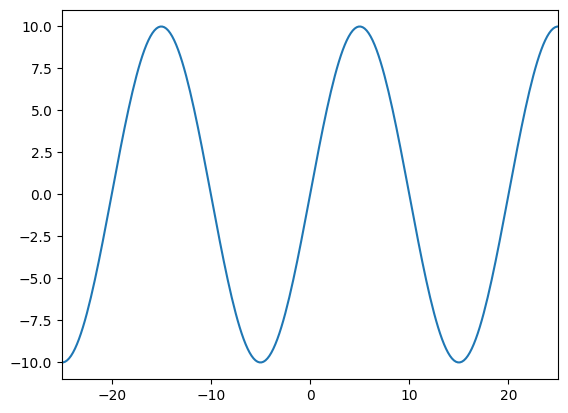

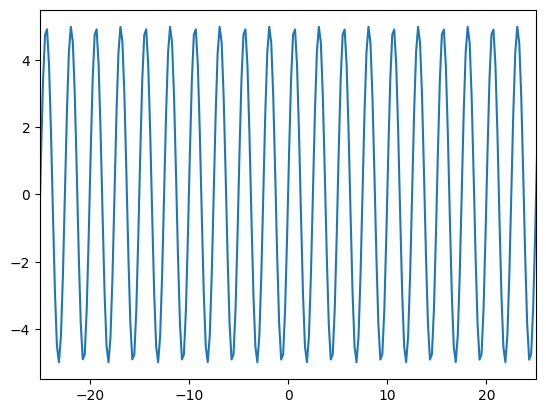

In [6]:
# Source generation
t = 10000
x_abs = np.linspace(-1000,1000,t)

S = np.zeros((2,t))
S[0,:] = 10*np.sin(2*np.pi*0.05*x_abs)
S[1,:] = 5*np.sin(2*np.pi*0.4*x_abs)

plt.figure(),plt.plot(x_abs,S[0,:])
plt.xlim([-25,25])
plt.figure(),plt.plot(x_abs,S[1,:])
plt.xlim([-25,25])

Here, we will transform the sources signals S into the DCT domain.

What is the objective of using the DCT?

Plot the above DCT and justify what you see. Pay attention to the labeling of the x-axis. Try with sines of various frequencies.

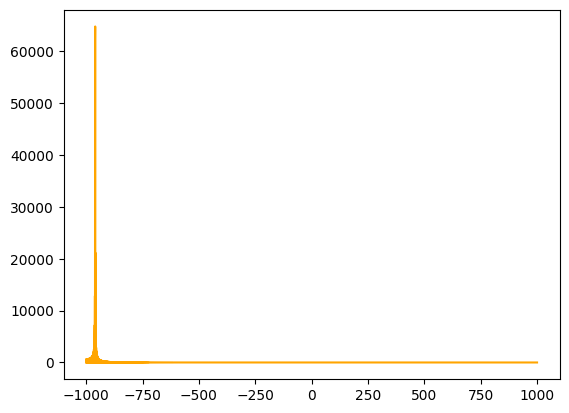

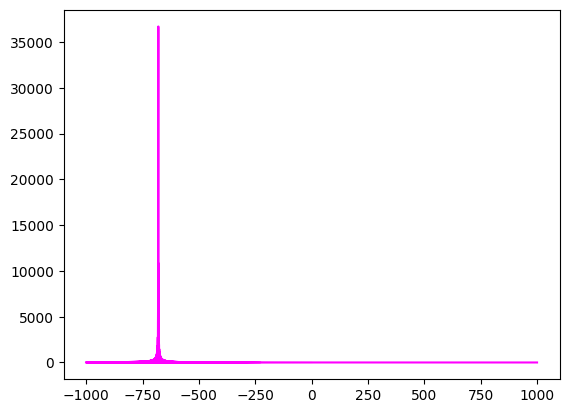

In [7]:
# Transformation into the DCT domain
Sf = sff.dct(S)

plt.plot(x_abs, abs(Sf[0,:]), c='orange')
plt.show()
plt.plot(x_abs, abs(Sf[1,:]), c='magenta')
plt.show()

We see a pic in each signal at a different abscise. We can easily separate the signals thanks to the pics. 

Data generation : now, we will create a mixture X = AS + N.

Plot the mixtures. Explain what you see.

Compute the DCT of X. Plot it and explain. Which caracteristic of the DCT will we use to recover the sources?

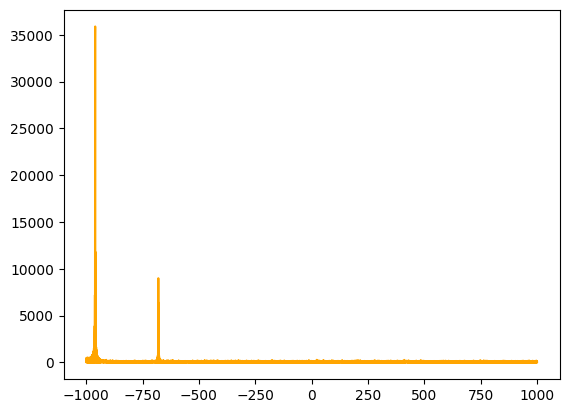

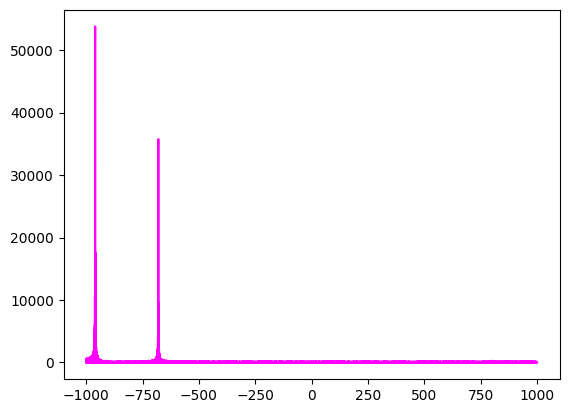

In [8]:
A = np.array([[0.5547002 , 0.24253563],
       [0.83205029, 0.9701425 ]]) # You can try other A values, but the columns must have a unitary norm.

X = A @ S
X = X + 0.5*np.random.randn(np.shape(X)[0],np.shape(X)[1])# You can try other noise values

# Transformation into the DCT domain
Xf = sff.dct(X)

plt.plot(x_abs, abs(Xf[0,:]), c='orange')
plt.show()
plt.plot(x_abs, abs(Xf[1,:]), c='magenta')
plt.show()

We observe the two pics in each signal. We could separate in the DCT domain and then do the DCT inverse to go back in the real domain.

**2) Source separation**

Now that we generated observations from simulated sources, we will focus on the source separation problem: recovering the sources from the observations (and the knowledge of A, since we are here in the non-blind setting).

To do that, we propose here to solve the source separation problem using a sparsity constraint on the sources. The cost function will then be minimized using the ISTA algorithm.

First, write the cost function we want to minimize to perform non-blind sparse source separation. Explain each term (in particular, which one is smooth or not). Is this cost function convex?


We want to minimize $$ \frac{1}{2}||X-AS||^2_F + λ || S ||_1 $$
The first term is the data attachement while the second is to ensure that S is sparse. This cost function is convex as a sum of two convex functions but the regularization term is not differenciable. 

Compute the gradient along the S variable of the data-fidelity term.

We have $$ ∇_S (\frac{1}{2}||X-AS||^2_F) = -A^T(X-AS) $$

Recall what the proximal operator of the l1-norm is.

In [9]:
# TO DO: implement the proximal operator of the l1-norm in the above function:
def prox_l1(S_est,thrd):
  # To complete
  S_est[S_est > thrd] -= thrd
  S_est[S_est <= -thrd] += thrd
  S_est[abs(S_est) < thrd] = 0

  return S_est

Explain the main idea of the ISTA algorithm. Then, implement it.

ISTA algorithm is an algorithm to minimize the cost function. It's an expension of the gradient descent with a function that is not differentiable but in which we can compute the proximal operator. 

Here we can use that because we only want to minimize under S (we know A)

In [10]:
# TO DO: implement the ISTA algorithm to minimize the cost function you wrote in question II-2-1.
def ISTA(X,A = np.eye(2),n=2,lamb=0,nbIt = 100):

  # Initialization of S_est
  t = X.shape[1]
  S_est = np.zeros((n, t))

  # Update of S_est
  gamma = 0.9 / (np.linalg.norm(A.T @ A) + 1e-6)
  for i in range(nbIt):
    grad_h = -A.T @ (X - A@S_est)
    S_est = prox_l1(S_est - gamma*grad_h, gamma*lamb)
    
  return S_est

It's now time to play with the code : launch the ISTA algorithm and look at the results.

Try various lamb values. What is the minimum value you should no go below? What is the issue with choosing too big values?

In [11]:
S_estf = ISTA(Xf,A = A,n=2,lamb=1000,nbIt = 1000)

Plot the estimated sources in the DCT domain. What kind of sparsity to they exhibit? Why?

The ISTA algorithm enables to separate and find the right abscise. The sparsity is shown by the only pic in each signal.

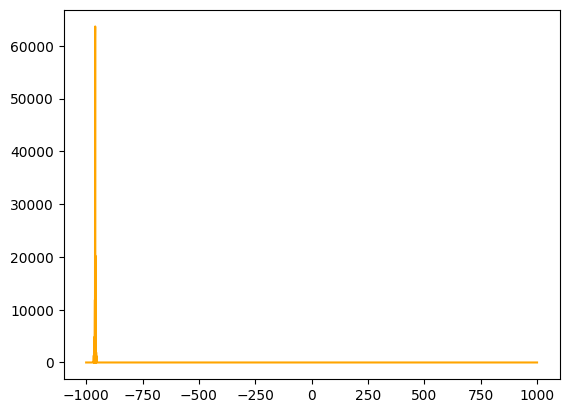

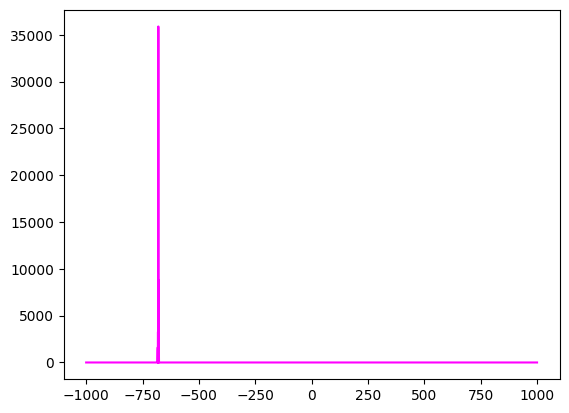

In [12]:
plt.plot(x_abs, abs(S_estf[0,:]), c='orange')
plt.show()
plt.plot(x_abs, abs(S_estf[1,:]), c='magenta')
plt.show()

Transform the sources back in the direct domain. Plot them. What do you see? Explain the differences with the original sources. Conclude.

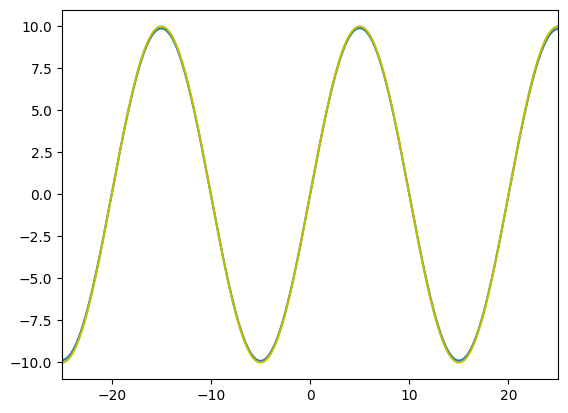

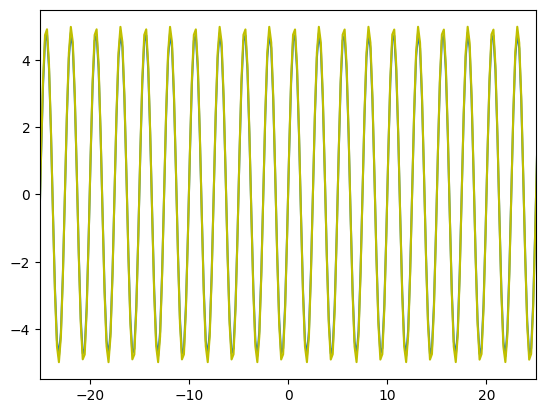

In [13]:
S_dir = sff.idct(S_estf)
plt.plot(x_abs, S[0].max()*S_dir[0]/S_dir[0].max())
plt.xlim([-25,25])
plt.plot(x_abs, S[0], c='y')
plt.xlim([-25,25])
plt.show()
plt.plot(x_abs, S[1].max()*S_dir[1]/S_dir[1].max())
plt.xlim([-25,25])
plt.plot(x_abs, S[1], c='y')
plt.xlim([-25,25])
plt.show()

The frequency is very good. However we lost the information of the amplitude. The energy is not the same! The oblique constraint could be a solution to ensure the conservation of the energy.

**III - Blind Source Separation : PALM**

Let's now delve into the core problem : *blind* source separation, in which **A** is unknown. To leverage sparsity, we will use the PALM algorithm.

Thoughout this whole section, we will re-use the same synthetic data as above (i.e., the one generated in II-1).

Write the cost function we want to minimize to perform *blind* sparse source separation. Explain each term (in particular, which one is smooth or not). Is this cost function convex?




We want to minimize under A and S $$ \frac{1}{2}||X-AS||^2_F + λ || S ||_1 + ι_{||A_{:,j}||^2 ≤ 1} (A) $$

The new term is the oblique constraint. It is here to conserve the energy.

The function is not differentiable and because of the oblique constraint it is not even convex

Recall what the gradient of the data fidelity term over A is.

We have $$ ∇_A (\frac{1}{2}||X-AS||^2_F) = -(X-AS)S^T $$

Compte the proximal operator of the oblique constraint. Implement it.

The proximal operator is the Euclidian projection onto the unit ball.

In [91]:
def prox_oblique(A):
    # TO DO      
    for j in range(A.shape[1]):
      if np.linalg.norm(A[:, j]) > 1:
        A[:, j] /= np.linalg.norm(A[:, j])
    return A

Implement the PALM algorithm to minimize the cost function you wrote in III-1).

In [96]:
from tqdm import tqdm

def PALM(X,n=2,lamb=0,nbIt = 100):
    
  # TO DO
  # Initialization of A_est and S_est 
  t = X.shape[1]
  S_est = np.random.rand(n, t)
  A_est = np.random.rand(n, n)

  # Update of S_est and A_est
  for n_it in tqdm(range(nbIt)):
    gamma = 0.9 / np.linalg.norm(A_est.T @ A_est) 
    eta = 0.9 / np.linalg.norm(S_est @ (S_est.T))
    S_est = prox_l1(S_est + gamma * A_est.T @ (X - A_est@S_est), gamma*lamb)
    A_est = prox_oblique(A_est + eta * (X - A_est@S_est) @ (S_est.T))

  return A_est, S_est

Launch the PALM algorithm to retrieve both A and S from X. Plot your results. How good is the separation? The separation quality is usually well evaluated comparing the true and estimated A matrices.

In [100]:
A_est, S_est = PALM(Xf, n=2, lamb=5000, nbIt=100)

100%|██████████| 100/100 [00:00<00:00, 3164.20it/s]


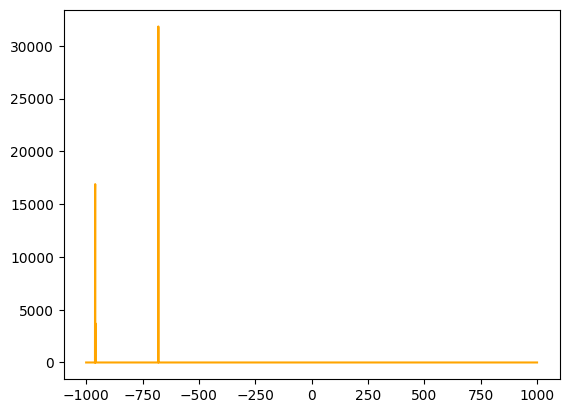

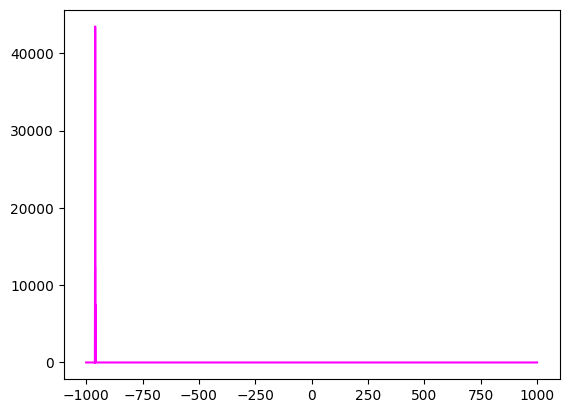

In [101]:
plt.plot(x_abs, abs(S_est[0,:]), c='orange')
plt.show()
plt.plot(x_abs, abs(S_est[1,:]), c='magenta')
plt.show()

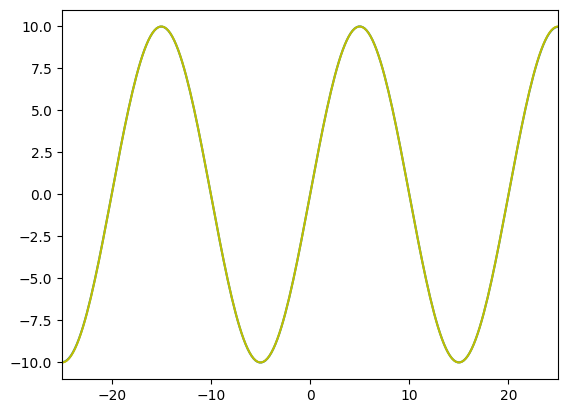

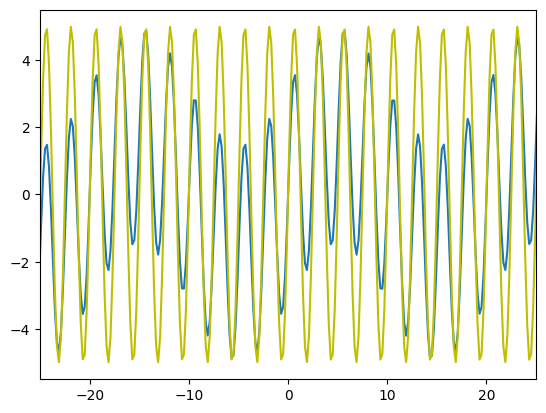

In [103]:
S_dir = sff.idct(S_est)
plt.plot(x_abs, S[0].max()*S_dir[1]/S_dir[1].max())
plt.xlim([-25,25])
plt.plot(x_abs, S[0], c='y')
plt.xlim([-25,25])
plt.show()
plt.plot(x_abs, S[1].max()*S_dir[0]/S_dir[0].max())
plt.xlim([-25,25])
plt.plot(x_abs, S[1], c='y')
plt.xlim([-25,25])
plt.show()

The separation is bad, I don't really know why.